# General imports

In [72]:
import numpy as np
import pyproj
import pyvista as pv
from matplotlib import pyplot as plt
import geopandas as gpd
from pathlib import Path

from geograypher.cameras.rig_cameras import create_rig_cameras_from_equirectangular
from geograypher.cameras.segmentor import SegmentorPhotogrammetryCameraSet
from geograypher.meshes import TexturedPhotogrammetryMesh
from geograypher.predictors.derived_segmentors import LookUpSegmentor
from geograypher.utils.indexing import find_argmax_nonzero_value
from geograypher.utils.visualization import show_segmentation_labels
from geograypher.utils.parsing import parse_metashape_mesh_metadata
from geograypher.utils.geospatial import convert_CRS_3D_points

from geograypher.constants import DATA_FOLDER, EARTH_CENTERED_EARTH_FIXED_CRS

# Processing parameters

In [73]:
# Skip re-computing the aggregation and use a saved version
USE_CACHED_AGGREGATION = False
# Aggregate images at this scale resolution
AGGREGATE_IMAGE_SCALE = 0.25

IDS_TO_LABELS = {0: "BO", 1: "CR", 2: "SH", 3: "HE", 4: "GR", 5: "LO", 6: "MA", 7: "SK"}
# Path to the camera data from metashape
CAMERAS_FILENAME = Path(DATA_FOLDER, "under-canopy", "under-canopy-cameras.xml")
# The path to the mesh data from metashape
MESH_FILENAME = Path(DATA_FOLDER, "under-canopy", "under-canopy-mesh.ply")
# The path to the mesh metadata from metashape
MESH_METADATA_FILENAME = Path(DATA_FOLDER, "under-canopy", "under-canopy-mesh-metadata.xml")
# Path to the images, resampled to frame camera representations
IMAGE_FOLDER = Path(DATA_FOLDER, "under-canopy", "under-canopy-images-reprojected")
# Path to the corresponding semantic segmentation predictions for the images
PREDICTED_IMAGE_LABELS_FOLDER = Path(DATA_FOLDER, "under-canopy", "under-canopy-images-reprojected-predictions")
# The location of the images when photogrammetry was run. Do not update this path unless you use completely new photogrammetry data.
ORIGINAL_IMAGE_FOLDER = "/ofo-share/repos/david/under-canopy-mapping/scratch/photogrammetry/st-0077-gopro-360-photos-timelapse"

# Outputs
AGGREGATED_FACE_LABELS_FILE = Path(DATA_FOLDER, "under-canopy", "aggregated_face_labels.npy")
VIS_MESH_PATH = Path(DATA_FOLDER, "under-canopy", "labeled_mesh.ply")
VIS_CAMERAS_MESH_PATH = Path(DATA_FOLDER, "under-canopy", "camera_rig_vis_mesh.ply")

# Define the rig camera
The imagery was originally an equirectangular representation of 360 degree data. To support both machine learning tasks and projections, it has been reprojected into six perspective views. These are analogous to how a traditional (non-spherical) camera views the world. The variables below describe these six orientations, which together fully capture the original 360 degree scene. 

In [74]:
RIG_CAMERA_DEF = {
    "f": 1440 / 2,
    "cx": 0.0,
    "cy": 0.0,
    "image_width": 1440,
    "image_height": 1440,
}
RIG_ORIENTATIONS = [
    {"yaw_deg": 0.0, "pitch_deg": 0.0, "roll_deg": 0.0},
    {"yaw_deg": 90.0, "pitch_deg": 0.0, "roll_deg": 0.0},
    {"yaw_deg": 180.0, "pitch_deg": 0.0, "roll_deg": 0.0},
    {"yaw_deg": 270.0, "pitch_deg": 0.0, "roll_deg": 0.0},
    {"yaw_deg": 0.0, "pitch_deg": -90.0, "roll_deg": 0.0},
    {"yaw_deg": 0.0, "pitch_deg": 90.0, "roll_deg": 0.0},
]
RESAMPLED_FORMAT_STR = "_yaw{yaw_deg:03.0f}_pitch{pitch_deg:03.0f}"

# Parse metadata
The mesh file format does not support metadata so it is saved in a sidecar file. Since the values of geospatial coordinates are large, quantization from the limits of float precision have a noticable impact. To counteract this, the mesh is saved with zero-centered coordinates, since float quantization is dependent on the scale of the value being represented. The metadata file provides a shift to apply to the data to produce the original values. Also, it provides a coordinate reference system (CRS) to interpret the values in.

In [75]:
mesh_CRS, mesh_shift = parse_metashape_mesh_metadata(MESH_METADATA_FILENAME)

# Load the camera set
Each original spherical camera is now represented by six perspective cameras all facing outward from the center location.

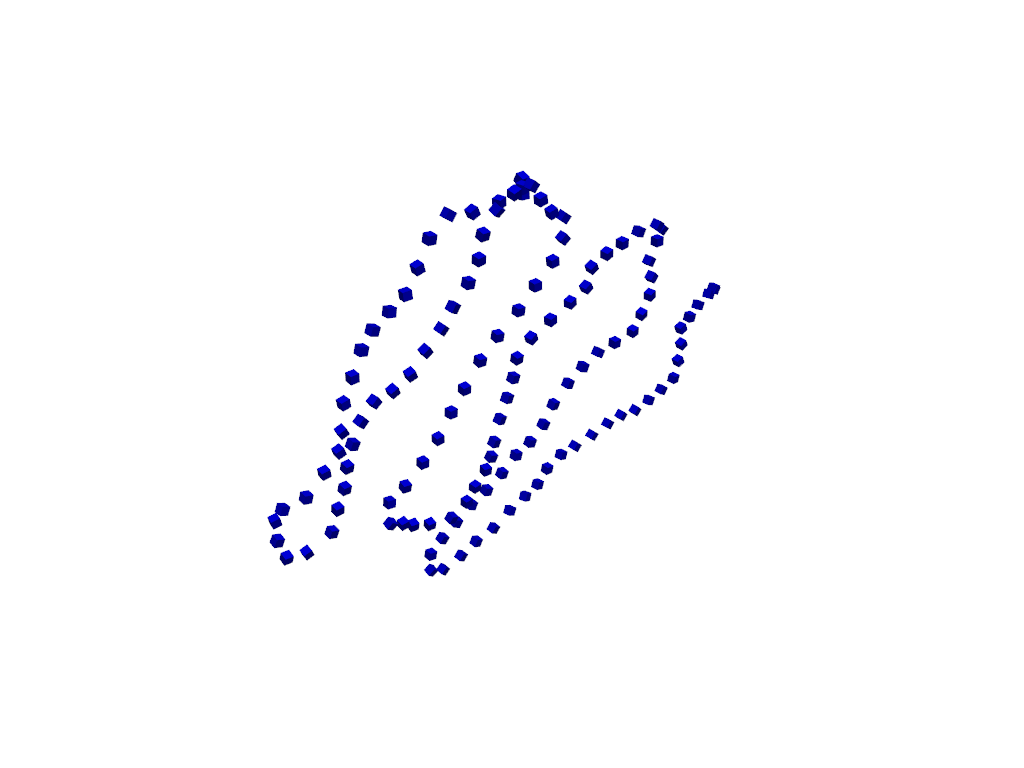

In [76]:
# Create camera set
camera_set = create_rig_cameras_from_equirectangular(
    camera_file=CAMERAS_FILENAME,
    original_images=ORIGINAL_IMAGE_FOLDER,
    perspective_images=PREDICTED_IMAGE_LABELS_FOLDER,
    rig_camera=RIG_CAMERA_DEF,
    rig_orientations=RIG_ORIENTATIONS,
    perspective_filename_format_str=RESAMPLED_FORMAT_STR
)

# And show
camera_set.vis(force_xvfb=True)

# Load the ROI
Create a region of interest from the camera locations so we don't texture areas of the mesh that are very far from cameras

<Axes: >

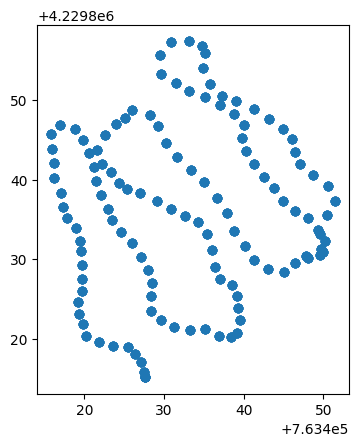

In [77]:
# Extract the region of interest around the camera locations
ROI = camera_set.get_camera_locations(as_CRS=mesh_CRS)
# Convert the ROI to a GeoDataFrame
xs, ys = zip(*ROI)
ROI = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xs, ys), crs=mesh_CRS)
ROI.plot()

# Load the mesh
Load the mesh, clipped to 25 meters from the camera locations. Once it's loaded, show it.

INFO:mesh_2034173610208:Loading mesh
INFO:mesh_2034173610208:Reading the mesh
INFO:mesh_2034173610208:Selecting an ROI from mesh
INFO:mesh_2034173610208:Standardizing ROI
INFO:mesh_2034173610208:Dissolving ROI
INFO:mesh_2034173610208:Setting CRS and buffering ROI
INFO:mesh_2034173610208:Dissolving buffered ROI
INFO:mesh_2034173610208:Extracting verts for dataframe
INFO:mesh_2034173610208:Checking intersection of verts with ROI
INFO:mesh_2034173610208:Extracting points from pyvista mesh
INFO:mesh_2034173610208:Extraction surface from subset mesh
INFO:mesh_2034173610208:Extracting faces from mesh
INFO:mesh_2034173610208:Loading texture
C:\Users\david\dev\geograypher\geograypher\meshes\meshes.py:2082: RuntimeWarning: invalid value encountered in cast
  vis_scalars = np.clip(vis_scalars, 0, 255).astype(np.uint8)


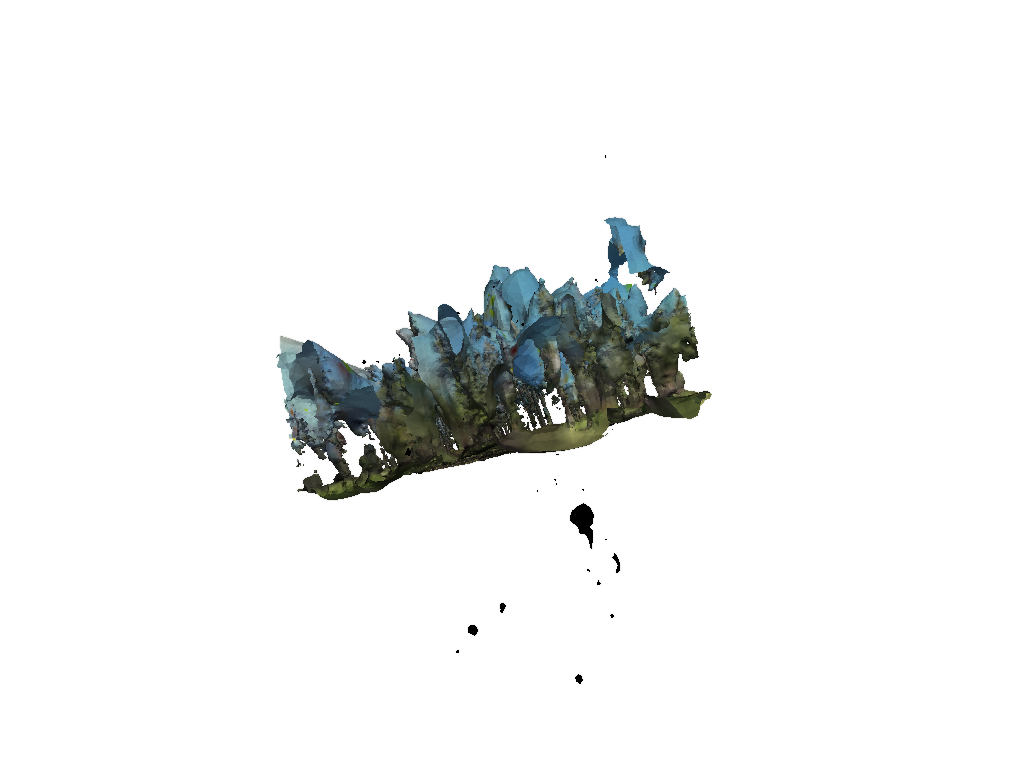

In [78]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    input_CRS=mesh_CRS,
    IDs_to_labels=IDS_TO_LABELS,
    ROI=ROI,
    ROI_buffer_meters=25,
    shift=mesh_shift,
)

mesh.vis()

# Show the predictions
Show a set of semantic segmentation predictions to ensure they look correct. The predictions are overlaid on the correponding images.

Showing segmentation labels:   0%|          | 0/10 [00:00<?, ?it/s]

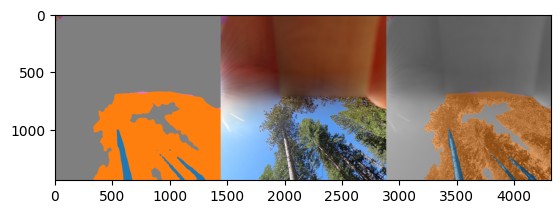

Showing segmentation labels:  10%|█         | 1/10 [00:00<00:06,  1.47it/s]

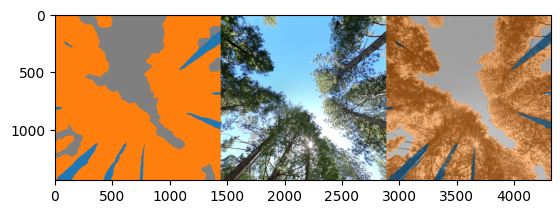

Showing segmentation labels:  20%|██        | 2/10 [00:01<00:05,  1.50it/s]

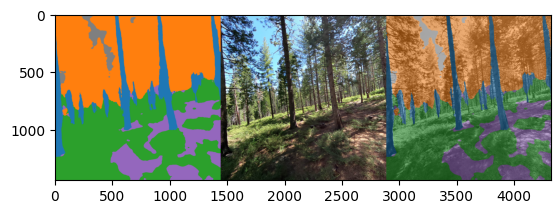

Showing segmentation labels:  30%|███       | 3/10 [00:01<00:04,  1.51it/s]

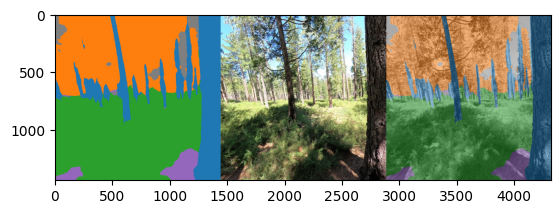

Showing segmentation labels:  40%|████      | 4/10 [00:02<00:03,  1.51it/s]

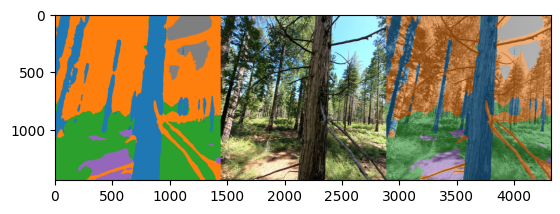

Showing segmentation labels:  50%|█████     | 5/10 [00:03<00:03,  1.52it/s]

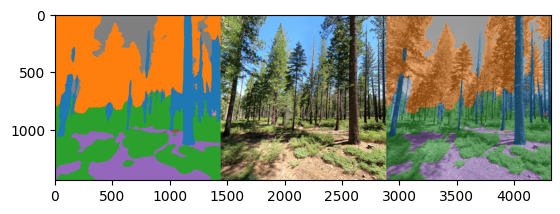

Showing segmentation labels:  60%|██████    | 6/10 [00:03<00:02,  1.52it/s]

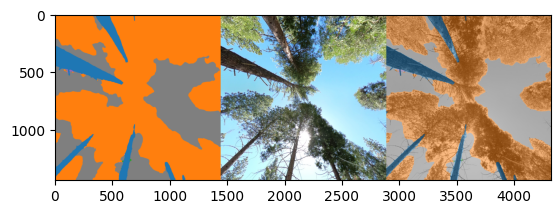

Showing segmentation labels:  70%|███████   | 7/10 [00:04<00:01,  1.52it/s]

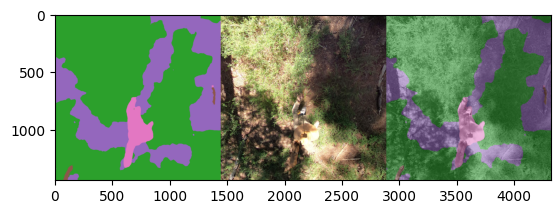

Showing segmentation labels:  80%|████████  | 8/10 [00:05<00:01,  1.52it/s]

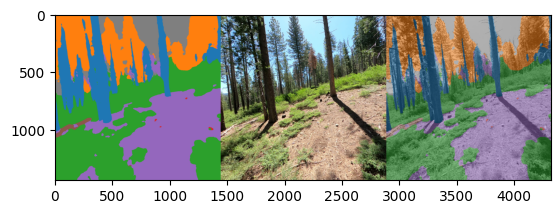

Showing segmentation labels:  90%|█████████ | 9/10 [00:05<00:00,  1.51it/s]

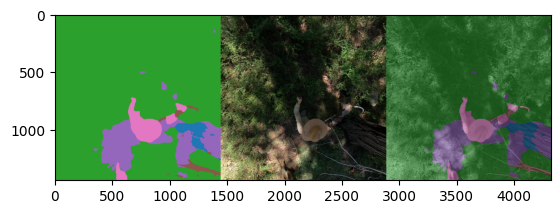

Showing segmentation labels: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


In [79]:
show_segmentation_labels(
    label_folder=PREDICTED_IMAGE_LABELS_FOLDER,
    image_folder=IMAGE_FOLDER,
    IDs_to_labels=IDS_TO_LABELS,
    image_suffix=".png",
)

# Return the segmented images
This creates an object that behaves like a camera set but returns the segmented image instead of the original RGB one.

In [80]:
# This gets a raw image and returns the corresponding segmentation labels
segmentor = LookUpSegmentor(
    base_folder=PREDICTED_IMAGE_LABELS_FOLDER,
    lookup_folder=PREDICTED_IMAGE_LABELS_FOLDER,
    num_classes=len(IDS_TO_LABELS),
)

# This wraps a camera set so it returns the corresponding segmentation label
segmentor_camera_set = SegmentorPhotogrammetryCameraSet(
    camera_set, segmentor=segmentor
)

# Project labels to mesh
Here the labels are finally projected to the mesh using techniques from computer graphics. Under the hood, this is performed with the OpenGL rendering stack.

In [81]:
# You can skip the expensive aggregation step by loading a cached version
if USE_CACHED_AGGREGATION and AGGREGATED_FACE_LABELS_FILE.is_file():
    aggregated_face_labels = np.load(AGGREGATED_FACE_LABELS_FILE)
else:
    # Otherwise, actually run agregation. This is slow, approximately 10-30 minutes depending on the system
    aggregated_face_labels, _ = mesh.aggregate_projected_images(
        segmentor_camera_set,
        aggregate_img_scale=AGGREGATE_IMAGE_SCALE,
        apply_distortion=False,
    )
    np.save(AGGREGATED_FACE_LABELS_FILE, aggregated_face_labels)

Aggregating projected viewpoints: 100%|██████████| 756/756 [10:15<00:00,  1.23it/s]


# Visualize results
Compute the most commonly projected class per face and show it

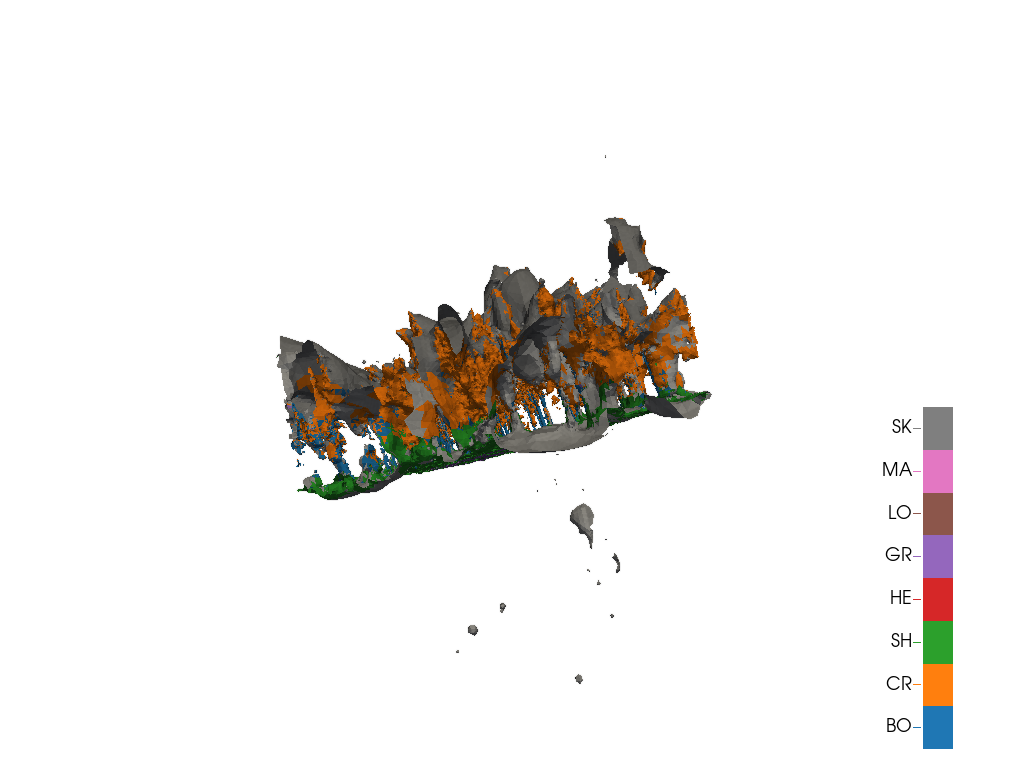

In [82]:
predicted_face_classes = find_argmax_nonzero_value(aggregated_face_labels, keepdims=True)
mesh.vis(vis_scalars=predicted_face_classes, IDs_to_labels=IDS_TO_LABELS)

# Save the results
Colormap the results and save them out

In [83]:
# Get the mesh in the original CRS and shift
pymesh = mesh.reproject_CRS(target_CRS=pyproj.CRS(mesh_CRS), inplace=False)
pymesh.points -= np.array([mesh_shift[0], mesh_shift[1], 0])
# Remove the previous coloring
assert pymesh.n_cells == len(predicted_face_classes)
del pymesh.point_data["RGB"]

# Colormap the values
colors = plt.colormaps["tab10"](predicted_face_classes.squeeze() / 10)
# Rescale to 0-255 and convert to uint8
colors = (colors * 255).astype(np.uint8)

# Add the colors to the mesh and save
pymesh.cell_data["RGB"] = colors
pymesh.save(VIS_MESH_PATH, texture="RGB")

# Save out the camera locations
Create a mesh representation of the camera locations for subsequent visualization

In [84]:
# Get the camera mesh in the local coordinate system
camera_mesh = camera_set.get_vis_mesh()
# Get the transform from this frame to the earth-centered earth-fixed frame
local_to_epsg_4978_transform = camera_set.get_local_to_epsg_4978_transform()
# Apply the transform to get the mesh in ECEF
camera_mesh.transform(local_to_epsg_4978_transform, inplace=True)

# Project the points from ECEF to the CRS that the scene mesh was provided in
reprojected_points = convert_CRS_3D_points(
    camera_mesh.points,
    input_CRS=EARTH_CENTERED_EARTH_FIXED_CRS,
    output_CRS=mesh_CRS
)
camera_mesh.points = reprojected_points

# Apply the same shift that was applied to the scene mesh to avoid quantization
camera_mesh.points -= np.array([mesh_shift[0], mesh_shift[1], 0])
# Save the camera mesh
camera_mesh.save(VIS_CAMERAS_MESH_PATH)